The chance-constrained optimization approach basically limits the RES output to a value smaller than maximum expected output. Since they are trying to maximize profits, the optimization problem will always push this constraint to the upper limit.

In [491]:
from scipy.stats import norm, beta, weibull_min, multivariate_normal
import matplotlib.pyplot as plt
import numpy as np
from random import choices
import seaborn as sns
plt.style.use({'figure.facecolor':'white'})

eta_conf = 95/100       # -
P_1_12_fore = 100       # kW
sigma_1_12_fore = 5     # kw

P_1_12 = P_1_12_fore + sigma_1_12_fore*norm.ppf(1 - eta_conf)
print(P_1_12)
print(norm.ppf(1 - eta_conf, loc=P_1_12_fore, scale=sigma_1_12_fore))

91.77573186524263
91.77573186524263


Juan paper: robust

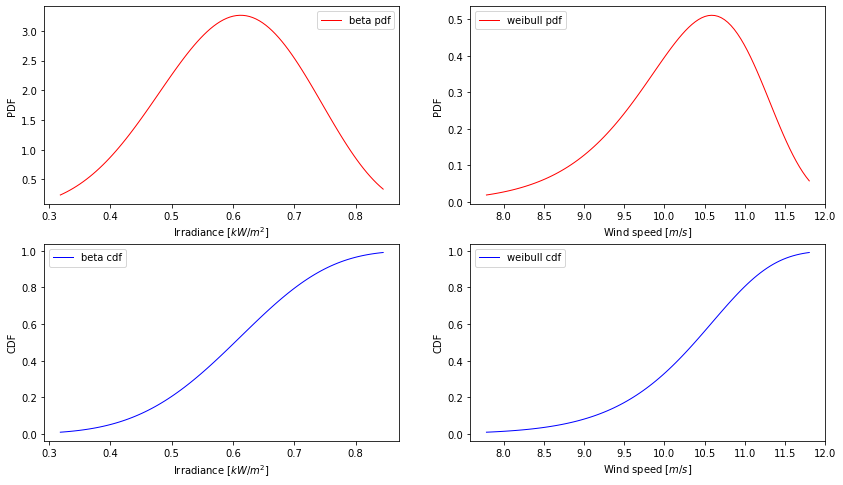

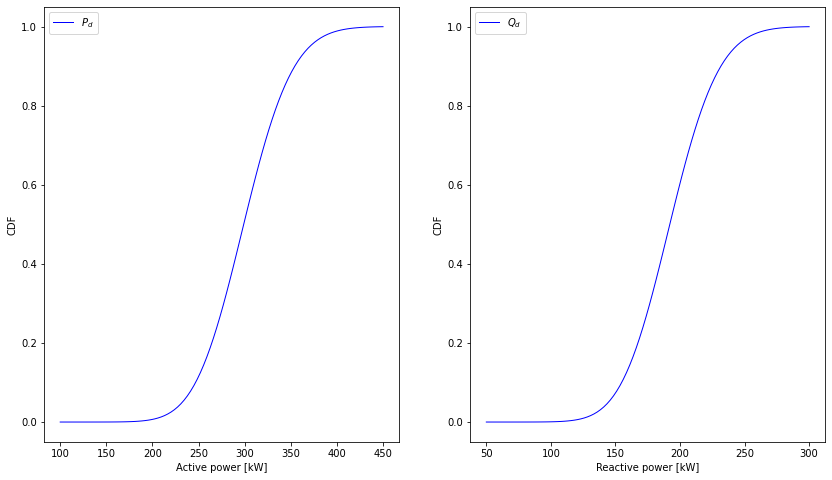

In [492]:
#wind params
kappa = 14.73   # shape
lambd = 10.64   # scale
#solar params
a = 9.82
b = 6.58
#load params
P_mu = 265
Q_mu = 176
P_sigma2 = 53**2
Q_sigma2 = 35.2**2
load_mean = np.array([P_mu, Q_mu])
load_cov = np.array([[P_sigma2, 0.6],[0.6, Q_sigma2]])
P = np.linspace(100,450,100)
Q = np.linspace(50,300,100)
load = np.column_stack((P, Q))
#define range of irradiances, wind speeds and demands from given distribution and parameters
irrad = np.linspace(beta.ppf(0.01, a, b), beta.ppf(0.99, a, b), 100)
wind = np.linspace(weibull_min.ppf(0.01, kappa, scale=lambd), weibull_min.ppf(0.99, kappa, scale=lambd), 100)
dem = multivariate_normal.cdf(load, mean=load_mean, cov=load_cov)
#plot probability density and cumulative distribution function for solar and wind (irrad & wind speed)
fig, ax = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(14,8))
ax[0,0].plot(irrad, beta.pdf(irrad, a, b), 'r-', lw=1, alpha=1, label='beta pdf');ax[0,0].set_xlabel('Irradiance [$kW/m^2$]');ax[0,0].set_ylabel('PDF');ax[0,0].legend()
ax[1,0].plot(irrad, beta.cdf(irrad, a, b), 'b-', lw=1, alpha=1, label='beta cdf');ax[1,0].set_xlabel('Irradiance [$kW/m^2$]');ax[1,0].set_ylabel('CDF');ax[1,0].legend()
ax[0,1].plot(wind, weibull_min.pdf(wind, kappa, scale=lambd), 'r-', lw=1, alpha=1, label='weibull pdf');ax[0,1].set_xlabel('Wind speed [$m/s$]');ax[0,1].set_ylabel('PDF');ax[0,1].legend()
ax[1,1].plot(wind, weibull_min.cdf(wind, kappa, scale=lambd), 'b-', lw=1, alpha=1, label='weibull cdf');ax[1,1].set_xlabel('Wind speed [$m/s$]');ax[1,1].set_ylabel('CDF');ax[1,1].legend();
#plot cdf of active and reactive power
fig2, ax2 = plt.subplots(nrows=1, ncols=2, squeeze=False, figsize=(14,8))
ax2[0,0].plot(P, dem, 'b-', lw=1, alpha=1, label='$P_d$');ax2[0,0].set_xlabel('Active power [kW]');ax2[0,0].set_ylabel('CDF');ax2[0,0].legend()
ax2[0,1].plot(Q, dem, 'b-', lw=1, alpha=1, label='$Q_d$');ax2[0,1].set_xlabel('Reactive power [kW]');ax2[0,1].set_ylabel('CDF');ax2[0,1].legend();

In [493]:
print('Selecting random variable from the distribution.')
print('PV irradiation: ', choices(irrad, beta.pdf(irrad, a, b))[0])
print('Wind speed: ', choices(wind, weibull_min.pdf(wind, kappa, scale=lambd))[0])

ws = choices(wind, weibull_min.pdf(wind, kappa, scale=lambd))[0]
wsin = 3        #Cut-in wind speed in (m/s)
wsr = 12        #Rated wind speed in (m/s)
wsout = 20      #Cut-off wind speed in (m/s)
Pwpp = 180      #Max. MW of the wind power plant

#calculate output power of wind turbine as a function of wind speed
if ws<wsin:
    Pwt = 0
elif wsin < ws < wsr:
    Pwt = Pwpp*(ws**3-wsin**3)/(wsr**3-wsin**3)
elif wsr < ws < wsout:
    Pwt_act = Pwpp
elif ws>wsout:
    Pwt_act = 0

print('Wind output power: ', Pwt, ' kW')

Selecting random variable from the distribution.
PV irradiation:  0.6853067251940019
Wind speed:  9.976719587476978
Wind output power:  110.10640955624311  kW


In [494]:
#check if choices function really follows given distribution (beta & weibull)
# check_w = []
# check_p = []
# for i in range(100000):
#     check_w.append(choices(wind, weibull_min.pdf(wind, kappa, scale=lambd))[0])
#     check_p.append(choices(irrad, beta.pdf(irrad, a, b))[0])

In [495]:
# plt.hist(check_w, bins=100);
# np.mean(check_w)

In [496]:
# plt.hist(check_p, bins=100);
# np.mean(check_p)


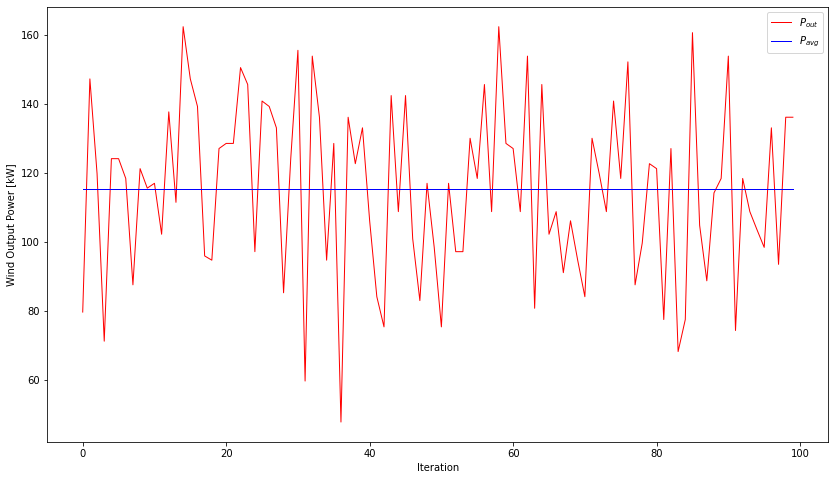

In [497]:
#monte carlo procedure - select x times random variable and calculate the output power of wind turbine
Pwt_act = []
for i in range(100):
    ws = choices(wind, weibull_min.pdf(wind, kappa, scale=lambd))[0]

    if ws<wsin:
        Pwt_act.append(0)
    elif wsin < ws < wsr:
        Pwt_act.append(Pwpp*(ws**3-wsin**3)/(wsr**3-wsin**3))
    elif wsr < ws < wsout:
        Pwt_act.append(Pwpp)
    elif ws>wsout:
        Pwt_act.append(0)

fig, ax = plt.subplots(squeeze=False, figsize=(14,8))
ax[0,0].plot(Pwt_act, 'r-', lw=1, alpha=1, label='$P_{out}$');ax[0,0].set_ylabel('Wind Output Power [kW]');ax[0,0].set_xlabel('Iteration')
avg = np.mean(Pwt_act)*np.ones(len(Pwt_act))
ax[0,0].plot(avg, 'b-', lw=1, alpha=1, label='$P_{avg}$');ax[0,0].legend();